In [1]:
%reload_ext nb_black
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, OPTICS, AffinityPropagation, AgglomerativeClustering
from pyclustering.cluster.kmedoids import kmedoids
import prince
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from umap import UMAP
from sklearn.metrics import silhouette_score

%matplotlib inline
from scipy import stats

plt.style.use(["dark_background"])
# %matplotlib ipympl

C:\Users\tayma\anaconda3\envs\py37\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


<IPython.core.display.Javascript object>

In [2]:
def plot_dendrogram(model, **kwargs):
    """
    A function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py

    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.

    Output: a dendrogram based on the model based in the parameters.

    Returns: None
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(
        float
    )

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

<IPython.core.display.Javascript object>

In [3]:
pd.options.display.max_columns = 50

<IPython.core.display.Javascript object>

In [4]:
url = "https://raw.githubusercontent.com/taylor-m/hcc_clustering/main/hcc_data/hcc-data-complete-balanced.csv"
df = pd.read_csv(url)
df.head()

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,Packs_year,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,67,137,15,0,1,1,"1,53",95,"13,7","106,6","4,9",99,"3,4","2,1",34,41,183,150,"7,1","0,7",1,"3,5","0,5","52,5",37,856,1
1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,62,0,0,0,1,1,"1,24","2,6","10,3",83,"6,1","1,71","3,9","0,8",11,28,77,120,7,"0,58",1,"1,8","0,85",32,10,18,1
2,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,1,1,78,50,50,2,1,2,"0,96","5,8","8,9","79,8","8,4",472,"3,3","0,4",58,68,202,109,7,"2,1",5,13,"0,1",28,6,16,1
3,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,77,40,30,0,1,1,"0,95",2440,"13,4","97,1",9,279,"3,7","0,4",16,64,94,174,"8,1","1,11",2,"15,7","0,2",131,78,1316,0
4,1,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,76,100,30,0,1,1,"0,94",49,"14,3","95,1","6,4",199,"4,1","0,7",147,306,173,109,"6,9","1,8",1,9,"0,1",59,15,22,1


<IPython.core.display.Javascript object>

In [5]:
bin_cols = [
    "Gender",
    "Symptoms",
    "Alcohol",
    "HBsAg",
    "HBeAg",
    "HBcAb",
    "HCVAb",
    "Cirrhosis",
    "Endemic",
    "Smoking",
    "Diabetes",
    "Obesity",
    "Hemochro",
    "AHT",
    "CRI",
    "HIV",
    "NASH",
    "Varices",
    "Spleno",
    "PHT",
    "PVT",
    "Metastasis",
    "Hallmark",
    "Class",
]

num_cols = [
    "Age",
    "Grams_day",
    "Packs_year",
    "INR",
    "AFP",
    "Hemoglobin",
    "MCV",
    "Leucocytes",
    "Platelets",
    "Albumin",
    "Total_Bil",
    "ALT",
    "AST",
    "GGT",
    "ALP",
    "TP",
    "Creatinine",
    "Major_Dim",
    "Dir_Bil",
    "Iron",
    "Sat",
    "Ferritin",
]

cat_cols = ["PS", "Encephalopathy", "Ascites", "Nodule"]

<IPython.core.display.Javascript object>

In [6]:
df[num_cols].head()

,Age,Grams_day,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Major_Dim,Dir_Bil,Iron,Sat,Ferritin
0,67,137,15,"1,53",95,"13,7","106,6","4,9",99,"3,4","2,1",34,41,183,150,"7,1","0,7","3,5","0,5","52,5",37,856
1,62,0,0,"1,24","2,6","10,3",83,"6,1","1,71","3,9","0,8",11,28,77,120,7,"0,58","1,8","0,85",32,10,18
2,78,50,50,"0,96","5,8","8,9","79,8","8,4",472,"3,3","0,4",58,68,202,109,7,"2,1",13,"0,1",28,6,16
3,77,40,30,"0,95",2440,"13,4","97,1",9,279,"3,7","0,4",16,64,94,174,"8,1","1,11","15,7","0,2",131,78,1316
4,76,100,30,"0,94",49,"14,3","95,1","6,4",199,"4,1","0,7",147,306,173,109,"6,9","1,8",9,"0,1",59,15,22


<IPython.core.display.Javascript object>

In [7]:
df[num_cols].columns

Index(['Age', 'Grams_day', 'Packs_year', 'INR', 'AFP', 'Hemoglobin', 'MCV',
       'Leucocytes', 'Platelets', 'Albumin', 'Total_Bil', 'ALT', 'AST', 'GGT',
       'ALP', 'TP', 'Creatinine', 'Major_Dim', 'Dir_Bil', 'Iron', 'Sat',
       'Ferritin'],
      dtype='object')

<IPython.core.display.Javascript object>

In [8]:
# changing "cols" to floats after replacing commas with decimals
cols = [
    "Packs_year",
    "INR",
    "AFP",
    "Hemoglobin",
    "MCV",
    "Leucocytes",
    "Platelets",
    "Albumin",
    "Total_Bil",
    "TP",
    "Creatinine",
    "Major_Dim",
    "Dir_Bil",
    "Iron",
    "Sat",
    "Ferritin",
]

for col in cols:
    df[col] = df[col].str.replace(",", ".")
df[cols] = df[cols].astype(float)

<IPython.core.display.Javascript object>

In [9]:
df[cols]

,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,TP,Creatinine,Major_Dim,Dir_Bil,Iron,Sat,Ferritin
0,15.0,1.53,95.0,13.7,106.6,4.9,99.00,3.40,2.10,7.1,0.70,3.5,0.50,52.5,37.0,856.0
1,0.0,1.24,2.6,10.3,83.0,6.1,1.71,3.90,0.80,7.0,0.58,1.8,0.85,32.0,10.0,18.0
2,50.0,0.96,5.8,8.9,79.8,8.4,472.00,3.30,0.40,7.0,2.10,13.0,0.10,28.0,6.0,16.0
3,30.0,0.95,2440.0,13.4,97.1,9.0,279.00,3.70,0.40,8.1,1.11,15.7,0.20,131.0,78.0,1316.0
4,30.0,0.94,49.0,14.3,95.1,6.4,199.00,4.10,0.70,6.9,1.80,9.0,0.10,59.0,15.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,7.0,1.33,502.6,11.1,102.8,6.9,90846.80,3.18,2.67,7.0,5.25,8.8,1.35,73.3,46.0,873.0
200,13.0,1.35,2353.7,12.2,95.2,6.7,332033.67,3.26,1.07,6.5,0.78,7.6,1.04,69.3,23.0,70.0
201,0.0,1.55,23.4,10.2,96.3,7.4,195.76,2.93,3.22,7.0,1.07,12.0,1.57,71.2,29.0,106.0
202,0.0,1.33,6.1,13.0,86.0,1118.4,101884.41,3.31,1.45,7.2,1.08,3.0,0.63,94.4,83.0,859.0


<IPython.core.display.Javascript object>

In [10]:
# changing Packs_year, Sat, and Ferritin columns to ints because they are whole nummber values
df.Packs_year = df.Packs_year.astype(int)
# df.Sat = df.Sat.astype(int)
# df.Ferritin = df.Ferritin.astype(int)

<IPython.core.display.Javascript object>

In [11]:
df.head()

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,Packs_year,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,67,137,15,0,1,1,1.53,95.0,13.7,106.6,4.9,99.00,3.4,2.1,34,41,183,150,7.1,0.70,1,3.5,0.50,52.5,37.0,856.0,1
1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,62,0,0,0,1,1,1.24,2.6,10.3,83.0,6.1,1.71,3.9,0.8,11,28,77,120,7.0,0.58,1,1.8,0.85,32.0,10.0,18.0,1
2,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,1,1,78,50,50,2,1,2,0.96,5.8,8.9,79.8,8.4,472.00,3.3,0.4,58,68,202,109,7.0,2.10,5,13.0,0.10,28.0,6.0,16.0,1
3,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,77,40,30,0,1,1,0.95,2440.0,13.4,97.1,9.0,279.00,3.7,0.4,16,64,94,174,8.1,1.11,2,15.7,0.20,131.0,78.0,1316.0,0
4,1,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,76,100,30,0,1,1,0.94,49.0,14.3,95.1,6.4,199.00,4.1,0.7,147,306,173,109,6.9,1.80,1,9.0,0.10,59.0,15.0,22.0,1


<IPython.core.display.Javascript object>

# Dimensionality Reduction

In [12]:
df.shape

(204, 50)

<IPython.core.display.Javascript object>

In [13]:
df_copy = df.copy()

<IPython.core.display.Javascript object>

In [14]:
cats = [
    "Gender",
    "Symptoms",
    "Alcohol",
    "HBsAg",
    "HBeAg",
    "HBcAb",
    "HCVAb",
    "Cirrhosis",
    "Endemic",
    "Smoking",
    "Diabetes",
    "Obesity",
    "Hemochro",
    "AHT",
    "CRI",
    "HIV",
    "NASH",
    "Varices",
    "Spleno",
    "PHT",
    "PVT",
    "Metastasis",
    "Hallmark",
    "Class",
    "PS",
    "Encephalopathy",
    "Ascites",
    "Nodule",
]

<IPython.core.display.Javascript object>

In [15]:
for cat in cats:
    df_copy[cat] = df_copy[cat].astype(str)

# df1.info()

<IPython.core.display.Javascript object>

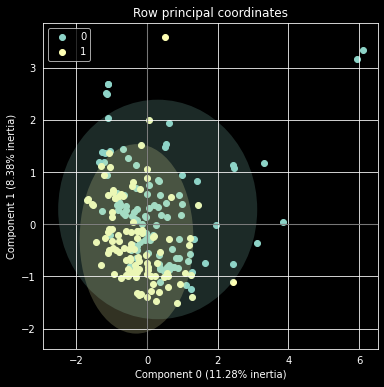

<IPython.core.display.Javascript object>

In [16]:
model = prince.FAMD()
famd = model.fit(df_copy)
coordinates = famd.transform(df_copy)

famd.plot_row_coordinates(df_copy, color_labels=df_copy.Class)
plt.show()

# Hierarchical Clustering

In [17]:
h_df = df.drop(columns="Class")
# scale data for cluster
scaler = StandardScaler()
# scaler = MinMaxScaler()
# looking at df with target var first
scaled = scaler.fit_transform(h_df)
scaled = pd.DataFrame(scaled, columns=h_df.columns, index=h_df.index)
scaled.head()

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,Packs_year,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin
0,0.509175,-1.496026,0.62270,-0.320473,-0.122169,-0.592447,-0.509175,0.338754,-0.25,1.103355,1.339597,-0.347677,4.188729,-0.762493,-0.407080,-0.122169,-0.227038,0.762493,-1.071153,-1.462348,-0.531995,-0.577350,0.722764,0.115368,0.979050,-0.144789,-0.938375,-0.396955,-0.662480,0.178727,-0.120701,0.452769,1.446105,-0.534480,-1.085670,-0.026441,-0.182386,-0.612635,-0.675653,-0.352266,-0.422567,-0.183792,-0.461648,-1.002113,-0.702832,-0.310458,-0.632454,-0.102464,0.957609
1,-1.963961,-1.496026,-1.60591,-0.320473,-0.122169,-0.592447,1.963961,0.338754,-0.25,1.103355,1.339597,-0.347677,-0.238736,1.311488,-0.407080,-0.122169,-0.227038,0.762493,-1.071153,-1.462348,-0.531995,-0.577350,0.722764,-0.276883,-1.194646,-0.485339,-0.938375,-0.396955,-0.662480,-0.423682,-0.121408,-1.111177,-1.450678,-0.534051,-1.086576,0.746335,-0.405016,-1.047899,-0.835282,-0.774469,-0.600674,-0.191449,-0.588186,-1.002113,-1.055468,-0.222874,-1.003364,-1.040800,-0.949676
2,0.509175,-1.496026,0.62270,3.120391,-0.122169,1.687915,-0.509175,0.338754,-0.25,1.103355,-0.746493,-0.347677,-0.238736,1.311488,2.456518,-0.122169,-0.227038,-1.311488,-1.071153,0.683832,-0.531995,1.732051,0.722764,0.978320,-0.401326,0.649827,0.733490,-0.396955,0.790702,-1.005319,-0.121383,-1.755155,-1.843462,-0.533229,-1.082197,-0.180996,-0.473518,-0.158446,-0.344117,-0.276588,-0.665980,-0.191449,1.014632,1.307843,1.267781,-0.410555,-1.075736,-1.179813,-0.954228
3,0.509175,0.668437,0.62270,-0.320473,-0.122169,-0.592447,-0.509175,0.338754,-0.25,1.103355,1.339597,-0.347677,-0.238736,1.311488,-0.407080,-0.122169,-0.227038,-1.311488,-1.071153,-1.462348,-0.531995,1.732051,0.722764,0.899870,-0.559990,0.195760,-0.938375,-0.396955,-0.662480,-1.026091,-0.102772,0.314773,0.280027,-0.533014,-1.083994,0.437225,-0.473518,-0.953276,-0.393233,-0.706757,-0.280082,-0.107228,-0.029309,-0.424624,1.827850,-0.385530,0.787860,1.322417,2.004567
4,0.509175,0.668437,0.62270,3.120391,-0.122169,1.687915,-0.509175,0.338754,-0.25,1.103355,-0.746493,-0.347677,-0.238736,1.311488,2.456518,-0.122169,-0.227038,-1.311488,-1.071153,-1.462348,-0.531995,-0.577350,0.722764,0.821420,0.391993,0.195760,-0.938375,-0.396955,-0.662480,-1.046864,-0.121053,0.728759,0.034537,-0.533944,-1.084739,1.055445,-0.422141,1.525836,2.578317,-0.392096,-0.665980,-0.199105,0.698287,-1.002113,0.438050,-0.410555,-0.514848,-0.867034,-0.940572


<IPython.core.display.Javascript object>

## Cosine, Average

In [18]:
# hierarchical clustering with distance matrix; metric = manhattan, linkage = average
clst = AgglomerativeClustering(n_clusters=4, affinity="cosine", linkage="average")
clst.fit(scaled)

# set cluster assignments in df
df["h_label"] = clst.labels_
print(df["h_label"].value_counts())

# plt.figure(figsize=(20, 10))
# plot_dendrogram(clst)

h_cluster_avgs = df.groupby("h_label").mean()
h_cluster_avgs.sort_values("Class").style.background_gradient()

0    91
1    67
3    25
2    21
Name: h_label, dtype: int64


,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,Packs_year,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
h_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,1.000000,0.800000,0.800000,0.120000,0.120000,0.440000,0.560000,1.000000,0.000000,0.600000,0.120000,0.040000,0.000000,0.080000,0.000000,0.000000,0.040000,0.760000,0.760000,0.720000,0.280000,0.280000,0.720000,54.240000,74.640000,16.920000,1.120000,1.360000,1.760000,1.509600,11359.140000,12.388000,97.220000,1731.648000,133603.724400,3.197600,11.241600,134.240000,227.120000,467.960000,384.200000,6.864000,1.476000,3.120000,4.216000,7.461600,128.356000,61.840000,865.120000,0.280000
0,0.912088,0.692308,0.967033,0.065934,0.000000,0.153846,0.076923,0.989011,0.043956,0.472527,0.461538,0.153846,0.109890,0.395604,0.164835,0.000000,0.021978,0.813187,0.637363,0.945055,0.285714,0.208791,0.736264,69.164835,105.340659,19.736264,1.637363,1.307692,1.703297,1.586901,27112.104725,12.060440,95.830769,1247.371429,107791.949670,3.232967,2.795165,57.208791,80.582418,269.450549,194.659341,6.762637,1.053297,2.626374,6.169231,1.281209,82.751648,40.384835,372.928571,0.494505
1,0.507463,0.641791,0.388060,0.014925,0.000000,0.164179,0.223881,0.716418,0.074627,0.268657,0.402985,0.089552,0.000000,0.462687,0.179104,0.000000,0.104478,0.328358,0.253731,0.268657,0.119403,0.328358,0.552239,65.597015,37.477612,16.731343,0.597015,1.014925,1.044776,1.241642,5720.876119,13.488060,92.502985,1695.198507,131280.083582,3.646716,1.270000,52.119403,70.970149,212.522388,215.611940,7.022388,1.200000,2.701493,9.108955,0.551493,69.097015,29.853433,417.328358,0.522388
2,0.952381,0.714286,0.619048,0.428571,0.000000,0.809524,0.285714,0.952381,0.142857,0.761905,0.047619,0.047619,0.047619,0.285714,0.095238,0.142857,0.000000,0.666667,0.714286,0.809524,0.190476,0.142857,0.571429,63.000000,66.523810,48.619048,0.571429,1.000000,1.333333,1.391905,5023.238095,13.480952,94.961905,1699.195238,88441.709524,3.743810,1.198571,70.761905,86.809524,234.095238,159.761905,32.409524,0.902857,2.857143,6.100000,0.714762,117.719048,44.202857,250.809524,0.714286


<IPython.core.display.Javascript object>

# K-Medoids Clustering

In [19]:
df.head()

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,...,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class,h_label
0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,67,137,...,0,1,1,1.53,95.0,13.7,106.6,4.9,99.00,3.4,2.1,34,41,183,150,7.1,0.70,1,3.5,0.50,52.5,37.0,856.0,1,0
1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,62,0,...,0,1,1,1.24,2.6,10.3,83.0,6.1,1.71,3.9,0.8,11,28,77,120,7.0,0.58,1,1.8,0.85,32.0,10.0,18.0,1,1
2,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,1,1,78,50,...,2,1,2,0.96,5.8,8.9,79.8,8.4,472.00,3.3,0.4,58,68,202,109,7.0,2.10,5,13.0,0.10,28.0,6.0,16.0,1,2
3,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,77,40,...,0,1,1,0.95,2440.0,13.4,97.1,9.0,279.00,3.7,0.4,16,64,94,174,8.1,1.11,2,15.7,0.20,131.0,78.0,1316.0,0,1
4,1,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,76,100,...,0,1,1,0.94,49.0,14.3,95.1,6.4,199.00,4.1,0.7,147,306,173,109,6.9,1.80,1,9.0,0.10,59.0,15.0,22.0,1,2


<IPython.core.display.Javascript object>

In [20]:
df = df.drop(columns="h_label")
df2 = df.drop(columns="Class")
df2.head()

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,Packs_year,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin
0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,67,137,15,0,1,1,1.53,95.0,13.7,106.6,4.9,99.00,3.4,2.1,34,41,183,150,7.1,0.70,1,3.5,0.50,52.5,37.0,856.0
1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,62,0,0,0,1,1,1.24,2.6,10.3,83.0,6.1,1.71,3.9,0.8,11,28,77,120,7.0,0.58,1,1.8,0.85,32.0,10.0,18.0
2,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,1,1,78,50,50,2,1,2,0.96,5.8,8.9,79.8,8.4,472.00,3.3,0.4,58,68,202,109,7.0,2.10,5,13.0,0.10,28.0,6.0,16.0
3,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,77,40,30,0,1,1,0.95,2440.0,13.4,97.1,9.0,279.00,3.7,0.4,16,64,94,174,8.1,1.11,2,15.7,0.20,131.0,78.0,1316.0
4,1,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,76,100,30,0,1,1,0.94,49.0,14.3,95.1,6.4,199.00,4.1,0.7,147,306,173,109,6.9,1.80,1,9.0,0.10,59.0,15.0,22.0


<IPython.core.display.Javascript object>

In [21]:
# scale data for cluster
scaler = StandardScaler()
# scaler = MinMaxScaler()
# looking at df with target var first
scaled = scaler.fit_transform(df2)
scaled = pd.DataFrame(scaled, columns=df2.columns, index=df2.index)
scaled.head()

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,Packs_year,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin
0,0.509175,-1.496026,0.62270,-0.320473,-0.122169,-0.592447,-0.509175,0.338754,-0.25,1.103355,1.339597,-0.347677,4.188729,-0.762493,-0.407080,-0.122169,-0.227038,0.762493,-1.071153,-1.462348,-0.531995,-0.577350,0.722764,0.115368,0.979050,-0.144789,-0.938375,-0.396955,-0.662480,0.178727,-0.120701,0.452769,1.446105,-0.534480,-1.085670,-0.026441,-0.182386,-0.612635,-0.675653,-0.352266,-0.422567,-0.183792,-0.461648,-1.002113,-0.702832,-0.310458,-0.632454,-0.102464,0.957609
1,-1.963961,-1.496026,-1.60591,-0.320473,-0.122169,-0.592447,1.963961,0.338754,-0.25,1.103355,1.339597,-0.347677,-0.238736,1.311488,-0.407080,-0.122169,-0.227038,0.762493,-1.071153,-1.462348,-0.531995,-0.577350,0.722764,-0.276883,-1.194646,-0.485339,-0.938375,-0.396955,-0.662480,-0.423682,-0.121408,-1.111177,-1.450678,-0.534051,-1.086576,0.746335,-0.405016,-1.047899,-0.835282,-0.774469,-0.600674,-0.191449,-0.588186,-1.002113,-1.055468,-0.222874,-1.003364,-1.040800,-0.949676
2,0.509175,-1.496026,0.62270,3.120391,-0.122169,1.687915,-0.509175,0.338754,-0.25,1.103355,-0.746493,-0.347677,-0.238736,1.311488,2.456518,-0.122169,-0.227038,-1.311488,-1.071153,0.683832,-0.531995,1.732051,0.722764,0.978320,-0.401326,0.649827,0.733490,-0.396955,0.790702,-1.005319,-0.121383,-1.755155,-1.843462,-0.533229,-1.082197,-0.180996,-0.473518,-0.158446,-0.344117,-0.276588,-0.665980,-0.191449,1.014632,1.307843,1.267781,-0.410555,-1.075736,-1.179813,-0.954228
3,0.509175,0.668437,0.62270,-0.320473,-0.122169,-0.592447,-0.509175,0.338754,-0.25,1.103355,1.339597,-0.347677,-0.238736,1.311488,-0.407080,-0.122169,-0.227038,-1.311488,-1.071153,-1.462348,-0.531995,1.732051,0.722764,0.899870,-0.559990,0.195760,-0.938375,-0.396955,-0.662480,-1.026091,-0.102772,0.314773,0.280027,-0.533014,-1.083994,0.437225,-0.473518,-0.953276,-0.393233,-0.706757,-0.280082,-0.107228,-0.029309,-0.424624,1.827850,-0.385530,0.787860,1.322417,2.004567
4,0.509175,0.668437,0.62270,3.120391,-0.122169,1.687915,-0.509175,0.338754,-0.25,1.103355,-0.746493,-0.347677,-0.238736,1.311488,2.456518,-0.122169,-0.227038,-1.311488,-1.071153,-1.462348,-0.531995,-0.577350,0.722764,0.821420,0.391993,0.195760,-0.938375,-0.396955,-0.662480,-1.046864,-0.121053,0.728759,0.034537,-0.533944,-1.084739,1.055445,-0.422141,1.525836,2.578317,-0.392096,-0.665980,-0.199105,0.698287,-1.002113,0.438050,-0.410555,-0.514848,-0.867034,-0.940572


<IPython.core.display.Javascript object>

In [22]:
# distance matrix
dist = pdist(scaled, metric="cosine")
dmat = squareform(dist)
dmat.shape

(204, 204)

<IPython.core.display.Javascript object>

In [23]:
# df of the distance matrix
dmat_df = pd.DataFrame(dmat, index=df.index, columns=df.index)

<IPython.core.display.Javascript object>

## K = 4

In [24]:
# generate k random indices from distance matrix
k = 4

np.random.seed(42)

n_rows = dmat.shape[0]
init_medoids = np.random.randint(0, n_rows, k)
# init_medoids

kmed = kmedoids(dmat, initial_index_medoids=init_medoids, data_type="distance_matrix")
kmed.process()

medoid_idxs = kmed.get_medoids()
# medoid_idxs

labels = kmed.predict(dmat)
df["kmed"] = labels

print(df.kmed.value_counts())
df.groupby("kmed").mean().sort_values("Class").style.background_gradient()

1    63
2    54
0    48
3    39
Name: kmed, dtype: int64


,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,Packs_year,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
kmed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.944444,0.851852,0.981481,0.055556,0.000000,0.148148,0.018519,1.000000,0.018519,0.333333,0.518519,0.074074,0.074074,0.500000,0.203704,0.000000,0.037037,0.851852,0.703704,1.000000,0.370370,0.333333,0.814815,70.166667,107.166667,13.962963,2.111111,1.388889,1.870370,1.754444,10106.629630,11.372222,97.124074,1209.281481,80147.161852,3.003333,3.033519,50.833333,79.685185,218.851852,175.203704,7.151852,1.080000,3.055556,6.470370,1.397037,75.942593,43.630000,521.942593,0.277778
3,0.948718,0.769231,0.717949,0.179487,0.076923,0.666667,0.615385,1.000000,0.076923,0.589744,0.128205,0.128205,0.076923,0.230769,0.000000,0.025641,0.025641,0.846154,0.743590,0.871795,0.230769,0.205128,0.641026,59.641026,76.435897,17.307692,1.076923,1.282051,1.717949,1.519231,9988.320513,13.005128,97.697436,1949.246154,126652.805385,3.256410,7.983590,127.153846,191.358974,353.692308,270.333333,15.738462,1.428974,2.974359,4.523077,5.288718,143.417949,67.088205,660.564103,0.384615
1,0.571429,0.825397,0.460317,0.079365,0.000000,0.126984,0.142857,0.666667,0.079365,0.301587,0.365079,0.063492,0.031746,0.428571,0.253968,0.000000,0.079365,0.206349,0.174603,0.238095,0.158730,0.380952,0.539683,66.936508,43.650794,17.841270,0.952381,1.079365,1.158730,1.200476,36414.098254,12.831746,91.252381,1958.750794,175203.917778,3.587460,1.143175,57.333333,81.555556,349.079365,297.365079,8.184127,1.211111,2.857143,10.285714,0.644286,63.884127,25.873016,386.174603,0.460317
0,0.791667,0.270833,0.770833,0.083333,0.000000,0.229167,0.166667,1.000000,0.062500,0.666667,0.354167,0.187500,0.041667,0.250000,0.041667,0.041667,0.041667,0.770833,0.645833,0.750000,0.125000,0.020833,0.645833,63.250000,80.041667,37.666667,0.270833,1.020833,1.166667,1.353083,220.334167,13.839583,94.566667,861.256250,72853.105417,3.789583,2.051458,46.333333,55.937500,161.875000,132.958333,8.802083,0.870000,2.020833,4.820833,0.683333,85.875000,32.229167,219.095833,0.895833


<IPython.core.display.Javascript object>

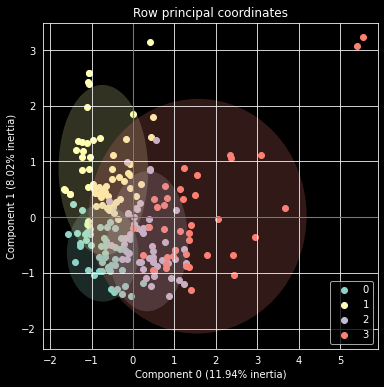

<IPython.core.display.Javascript object>

In [25]:
df_copy = df.copy()

for cat in cats:
    df_copy[cat] = df_copy[cat].astype(str)

model = prince.FAMD()
famd = model.fit(df_copy)
coordinates = famd.transform(df_copy)

famd.plot_row_coordinates(df_copy, color_labels=df_copy.kmed)
plt.show()

In [ ]:
# silhouette score for k-medoids, k=4
silhouette_score(df.drop(columns="kmed"), labels, metric="cosine")

-0.18836566126541415

<IPython.core.display.Javascript object>

In [ ]:
# silhouette score for k-medoids, k=4
silhouette_score(df.drop(columns="kmed"), labels, metric="euclidean")

## K = 3

In [ ]:
# generate k random indices from distance matrix
k = 3

np.random.seed(42)

n_rows = dmat.shape[0]
init_medoids = np.random.randint(0, n_rows, k)
# init_medoids

kmed = kmedoids(dmat, initial_index_medoids=init_medoids, data_type="distance_matrix")
kmed.process()

medoid_idxs = kmed.get_medoids()
# medoid_idxs

labels = kmed.predict(dmat)
df["kmed"] = labels

print(df.kmed.value_counts())
df.groupby("kmed").mean().sort_values("Class").style.background_gradient()

In [ ]:
df_copy = df.copy()

for cat in cats:
    df_copy[cat] = df_copy[cat].astype(str)

model = prince.FAMD()
famd = model.fit(df_copy)
coordinates = famd.transform(df_copy)

famd.plot_row_coordinates(df_copy, color_labels=df_copy.kmed)
plt.show()

In [ ]:
# silhouette score for k-medoids, k=3
silhouette_score(df.drop(columns="kmed"), labels, metric="cosine")

## K = 2

In [ ]:
# generate k random indices from distance matrix
k = 2

np.random.seed(42)

n_rows = dmat.shape[0]
init_medoids = np.random.randint(0, n_rows, k)
# init_medoids

kmed = kmedoids(dmat, initial_index_medoids=init_medoids, data_type="distance_matrix")
kmed.process()

medoid_idxs = kmed.get_medoids()
# medoid_idxs

labels = kmed.predict(dmat)
df["kmed"] = labels

print(df.kmed.value_counts())
df.groupby("kmed").mean().sort_values("Class").style.background_gradient()

In [ ]:
df_copy = df.copy()

for cat in cats:
    df_copy[cat] = df_copy[cat].astype(str)

model = prince.FAMD()
famd = model.fit(df_copy)
coordinates = famd.transform(df_copy)

famd.plot_row_coordinates(df_copy, color_labels=df_copy.kmed)
plt.show()

In [ ]:
# silhouette score for k-medoids, k=2
silhouette_score(df.drop(columns="kmed"), labels, metric="cosine")

# Affinity Propogation Clustering

In [ ]:
df = df.drop(columns="kmed")

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
scaled = pd.DataFrame(scaled, columns=df.columns, index=df.index)
scaled.head()

In [ ]:
# distance matrix
dist = pdist(scaled, metric="hamming")
dmat = squareform(dist)
dmat.shape

In [ ]:
# affinity propagation object
clustering = AffinityPropagation(
    random_state=42,
    affinity="precomputed",
    #     damping=0.9
).fit(dmat)

labels = clustering.labels_
df["ap_labels"] = labels

print(df.ap_labels.value_counts())

df.groupby("ap_labels").mean().sort_values("Class").style.background_gradient()

In [ ]:
df.head()

In [ ]:
# silhouette score for affinity propagation
silhouette_score(df.drop(columns="ap_labels"), labels, metric="euclidean")

# OPTICS Clustering

In [ ]:
df = df.drop(columns="ap_labels")
df.head()

In [ ]:
df_copy = df.copy()
scaler = StandardScaler()
scaled = scaler.fit_transform(df_copy)

In [ ]:
# clustering object
clustering = OPTICS(min_samples=3, metric="cosine", min_cluster_size=5).fit(scaled)
df["optics"] = clustering.labels_

print(df.optics.value_counts())
df.groupby("optics").mean().sort_values("Class").style.background_gradient()